In [1]:
import sys, os, glob
import ROOT as rt
import numpy as np
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import qol_util as qu

Welcome to JupyROOT 6.24/02


In [2]:
rt.gROOT.SetBatch(True)
style = 'dark'
ps = qu.PlotStyle(style)
ps.SetStyle()

In [3]:
rootfiles = glob.glob('*.root')

# sort rootfiles to be alphabetic
rootfiles.sort()

rootfiles = [rt.TFile(x,'READ') for x in rootfiles]

In [4]:
variables = ['nobj','pt','E','m','dr', 'dr2d'] # bookkeeping
nvars = len(variables)
d2 = np.full(nvars,False,dtype=bool)
d2[-1] = True

colors = [rt.kRed, rt.kViolet, rt.kBlue]
if(style == 'dark'): colors = [rt.kRed, ps.curve, rt.kSpring]

titles = []
for i in range(nvars): titles.append(';' + ';'.join(rootfiles[0].Get('s_{}'.format(i)).GetTitle().split(';')[1:]))
particles = ['constituents','top','bottom','W^{+}','jet']
npars = len(particles)

logx = [False, True, True, False, False, False]
logy = [False, True, True, True, True, True]
assert(len(logx) == len(logy) and len(logx) == nvars)

leg_entries = ['No MPI/ISR/FSR','With ISR/FSR','With MPI/ISR/FSR']
plot_names = [
    'nconsts',
    'pt',
    'e',
    'm',
    'dr',
    'dr2d'
]

In [5]:
# special naming for "unique variables" like nobj, dr (not plotted for each particle species)

spec_names = {
    0: 'constituents' + titles[0], # nobj only plotted for constituents
    5: 'top' # dR(x,jet) only plotted for x==top (this is a 2D plot)
    
}


In [6]:
ranges = [
    [[0,100]], # number of constituents,
    [[1.0e-2, 1000.], # consts
    [90.,1000.],# top
    [10., 10000.], # bottom
    [1.,2.0e3], # W
    [1.,1000.]# jet
    ], # pT,
    [[1.0e-2, 1000.], # consts
    [90.,5000.],# top
    [10., 2e4], # bottom
    [10.,5000.], # W
    [1.,5000.]# jet
    ], # Energy,
    [[0, 10.], # consts
    [0.,400.], # top
    [0, 10.], # bottom
    [0.,200.], # W
    [0.,400.] # jet
    ], # mass
    [[0.,2.], # top
    [0, 2.], # bottom
    [0.,2.], # W
    ] # dR   
]

In [7]:
#rootfiles[0].ls()

In [8]:
canvases = []
hists = []
legends = []
for i in range(nvars):
    c = rt.TCanvas(qu.RN(),'c_{}'.format(i),1600,1200)
    leg = rt.TLegend(0.7,0.75,0.9,0.9)
    leg.SetFillColorAlpha(ps.canv, 0.5)
    
    #print('i = {}'.format(i))
    
    hists = rootfiles[0].Get('s_{}'.format(i)).GetHists()
        
    K = len(hists)
    if(K in [3,4]): c.Divide(2,2)
    elif(K == 5): c.Divide(2,3)

    for j, rfile in enumerate(rootfiles):
        #print('\tj = {}'.format(j))
        hists = rfile.Get('s_{}'.format(i)).GetHists()
        
        for k in range(K):
            #print('\t\tk = {}'.format(k))
            if(K > 1): c.cd(k+1)
            else: c.cd()
                
            h = hists[k]
            
            if(K == 1): name = spec_names[i]
            elif(i == 4): name = particles[k+1] + titles[i] # for dR, skip constituents
            else: name = particles[k] + titles[i]
            h.SetTitle(name)
            
            if(not d2[i]): 
                h.Draw('SAME HIST')
                h.SetLineColor(colors[j])
                
            else: 
                rt.gPad.SetRightMargin(0.125)
                h.Draw('COLZ')
                palette = h.GetListOfFunctions()[0]
                palette.SetX1NDC(0.825)
                palette.SetX2NDC(0.875)
                #h.GetZaxis().SetLabelSize(0.02)
                h.GetZaxis().SetMaxDigits(2)

            rt.gPad.SetLogx(logx[i])
            rt.gPad.SetLogy(logy[i])
            
            # TODO
            # It seems that PlotStyle isn't working correctly for these hists
            # extracted from the THStack, some but not all things set correctly.
            for ax in [h.GetXaxis(), h.GetYaxis(), h.GetZaxis()]:
                ax.SetTitleColor(ps.text)
                ax.SetLabelColor(ps.text)
                ax.SetAxisColor(ps.main)
                rt.gPad.SetFrameLineColor(ps.main)
                    
            if(not d2[i]): h.GetXaxis().SetRangeUser(*(ranges[i][k]))
            hists.append(h)
            if(k==0): leg.AddEntry(h,leg_entries[j],'l')

    if(K == 1): 
        if(not d2[i]): leg.Draw()
    else:
        for k in range(K):
            c.cd(k+1)
            leg.Draw()
             
    leg.SetTextColor(ps.text)
    legends.append(leg)
    canvases.append(c)

Info in <TCanvas::Print>: png file nconsts.png has been created
Info in <TCanvas::Print>: png file pt.png has been created
Info in <TCanvas::Print>: png file e.png has been created
Info in <TCanvas::Print>: png file m.png has been created
Info in <TCanvas::Print>: png file dr.png has been created
Info in <TCanvas::Print>: png file dr2d.png has been created


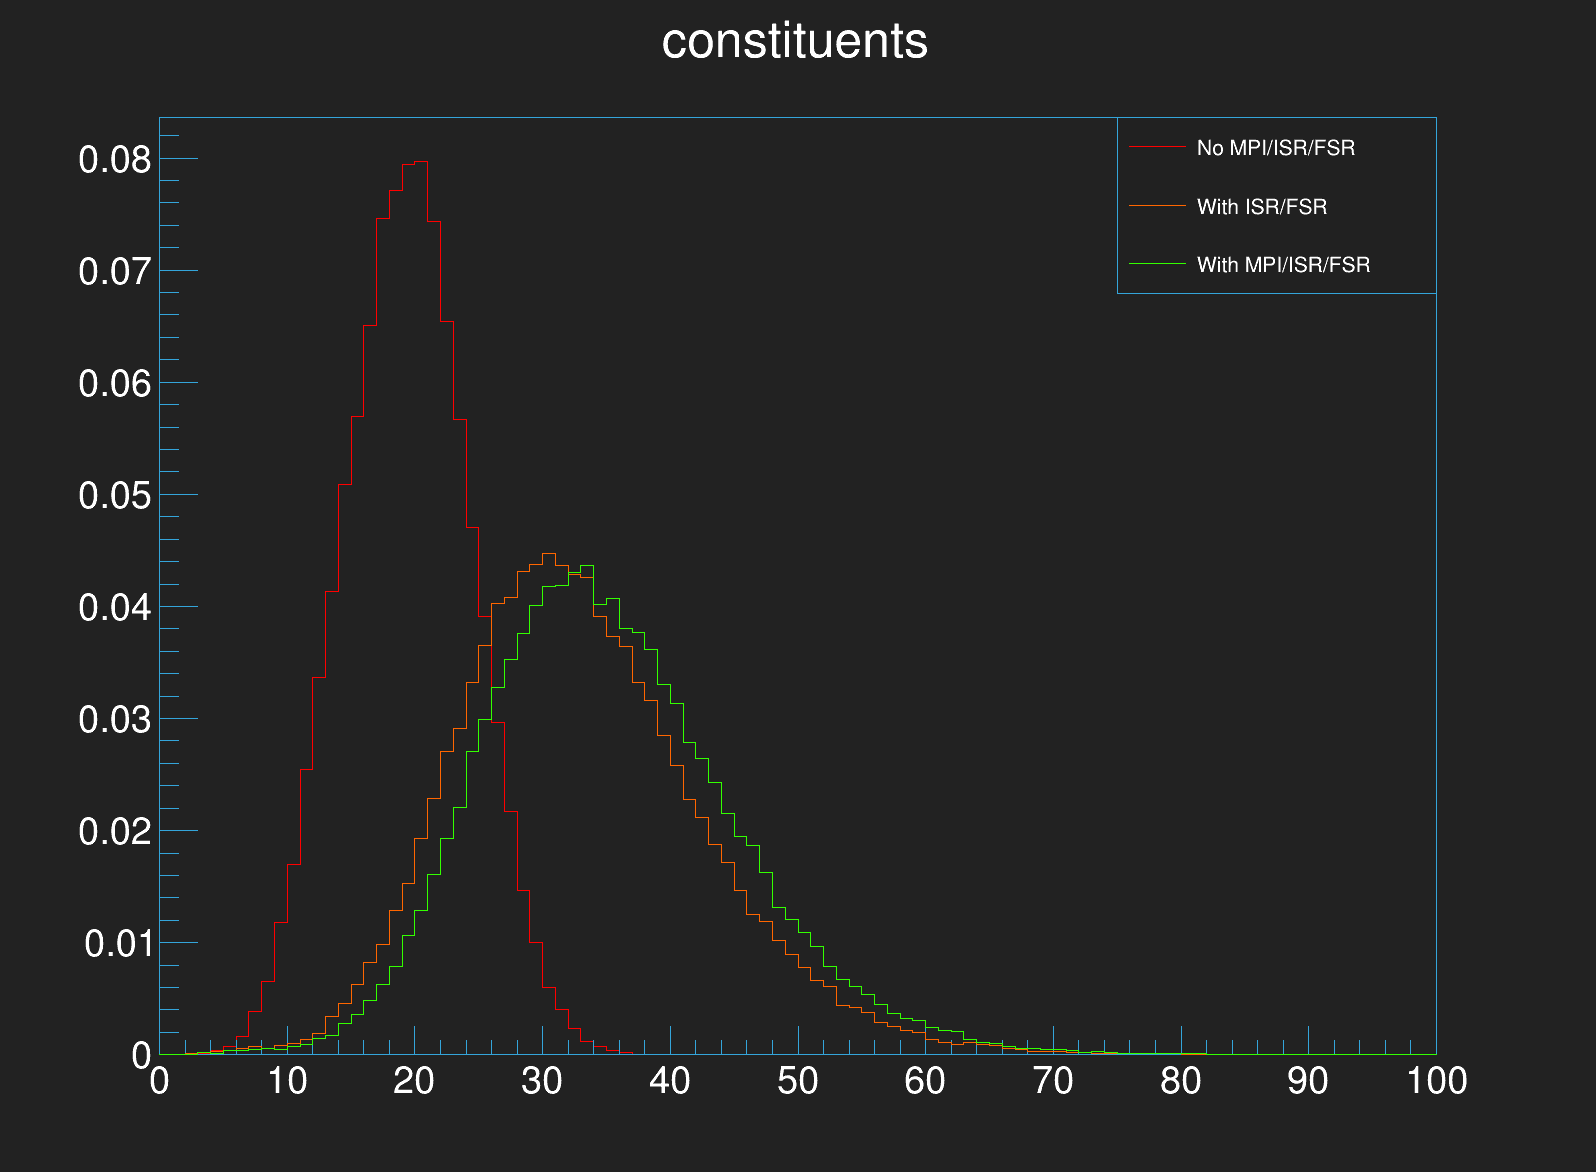

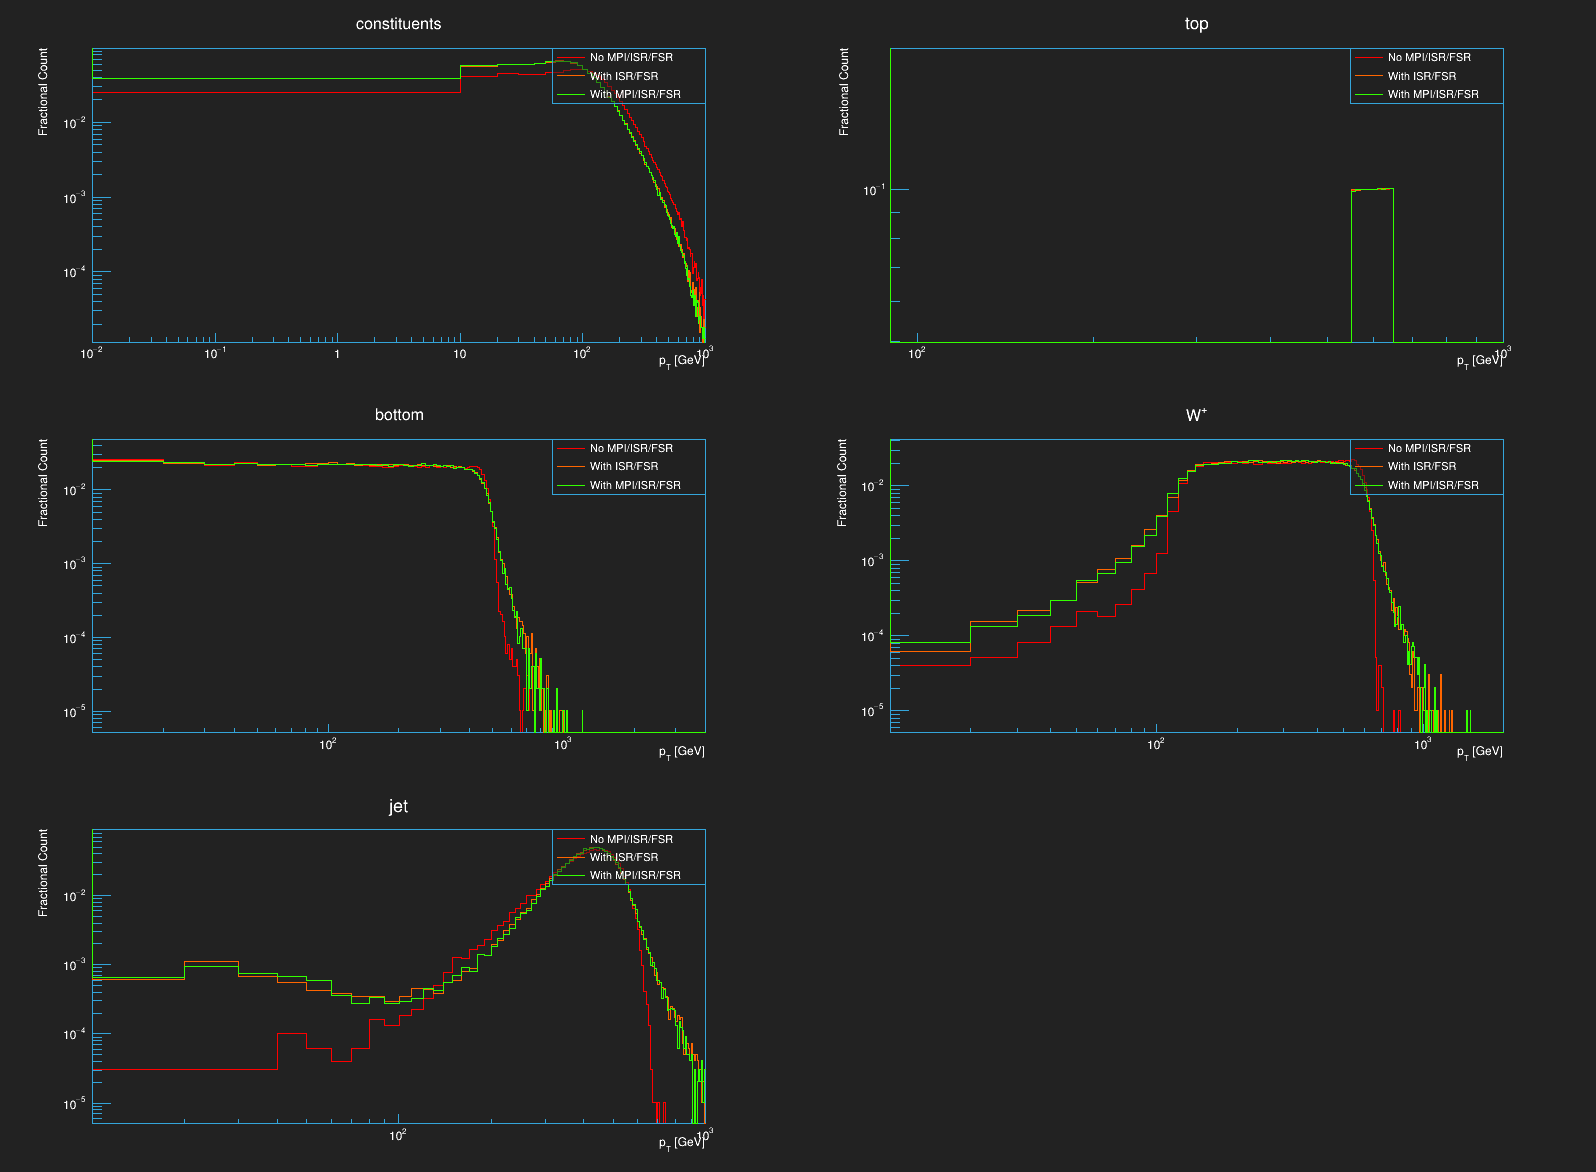

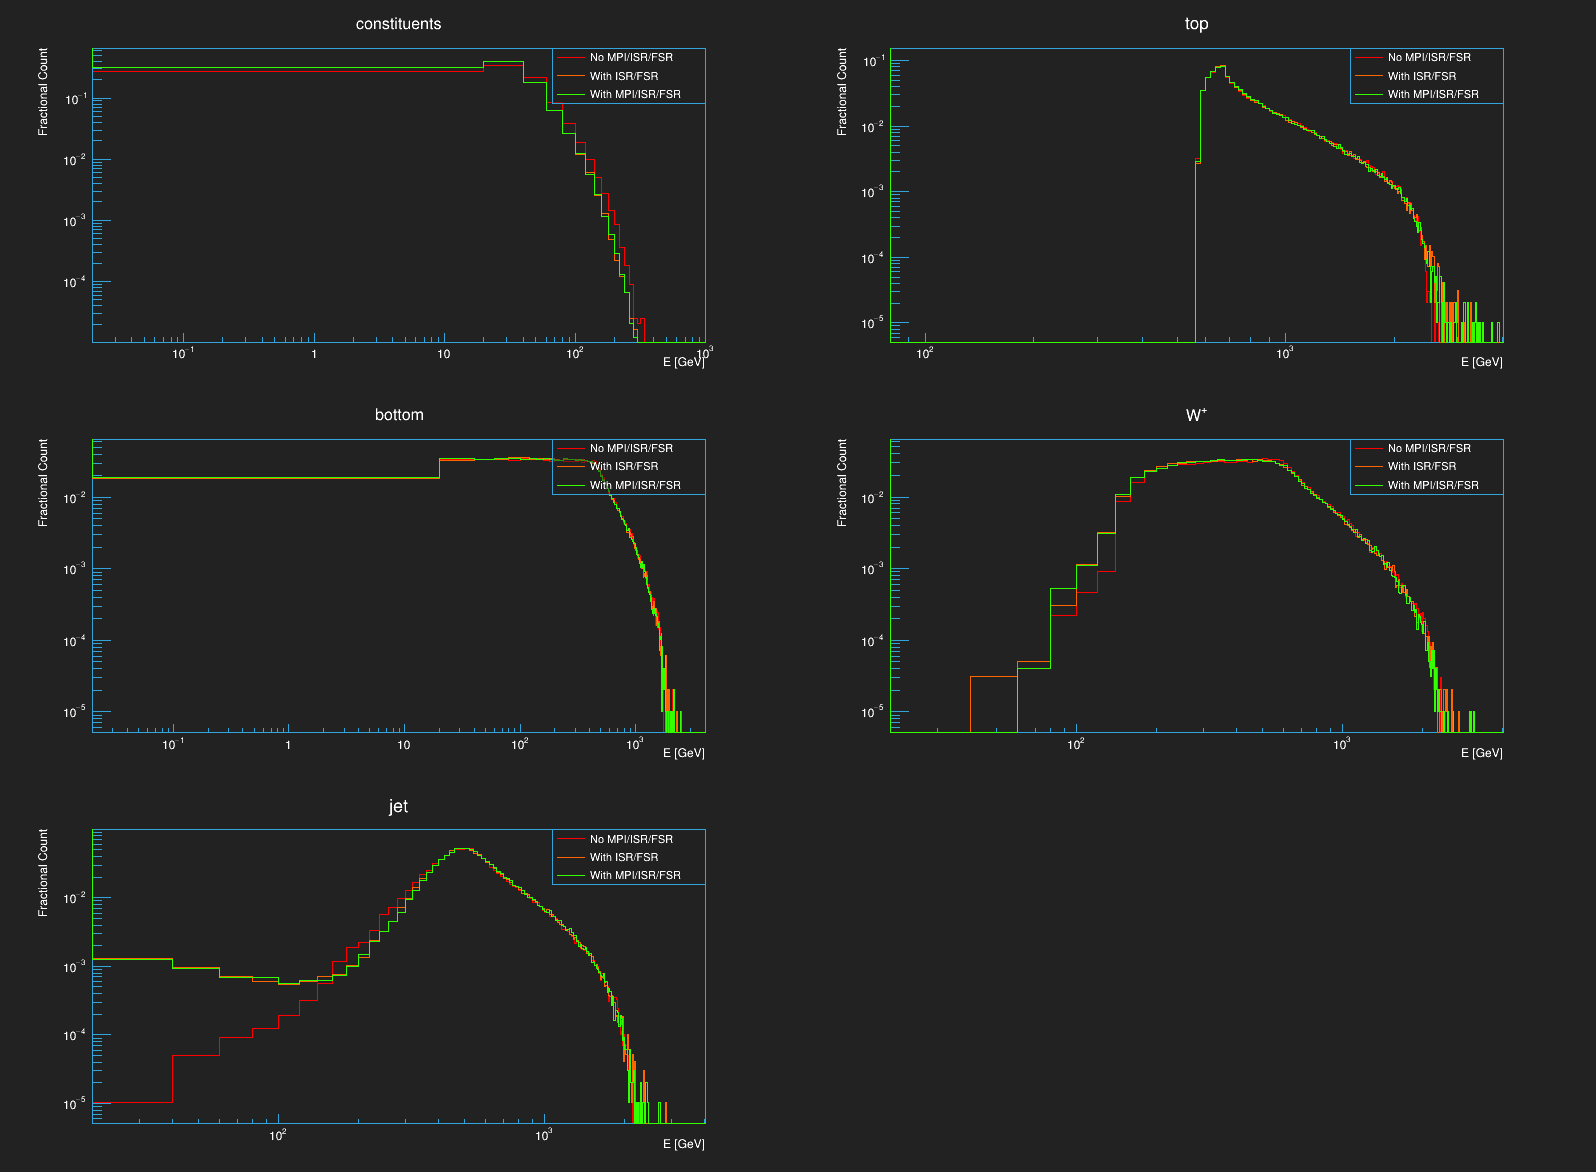

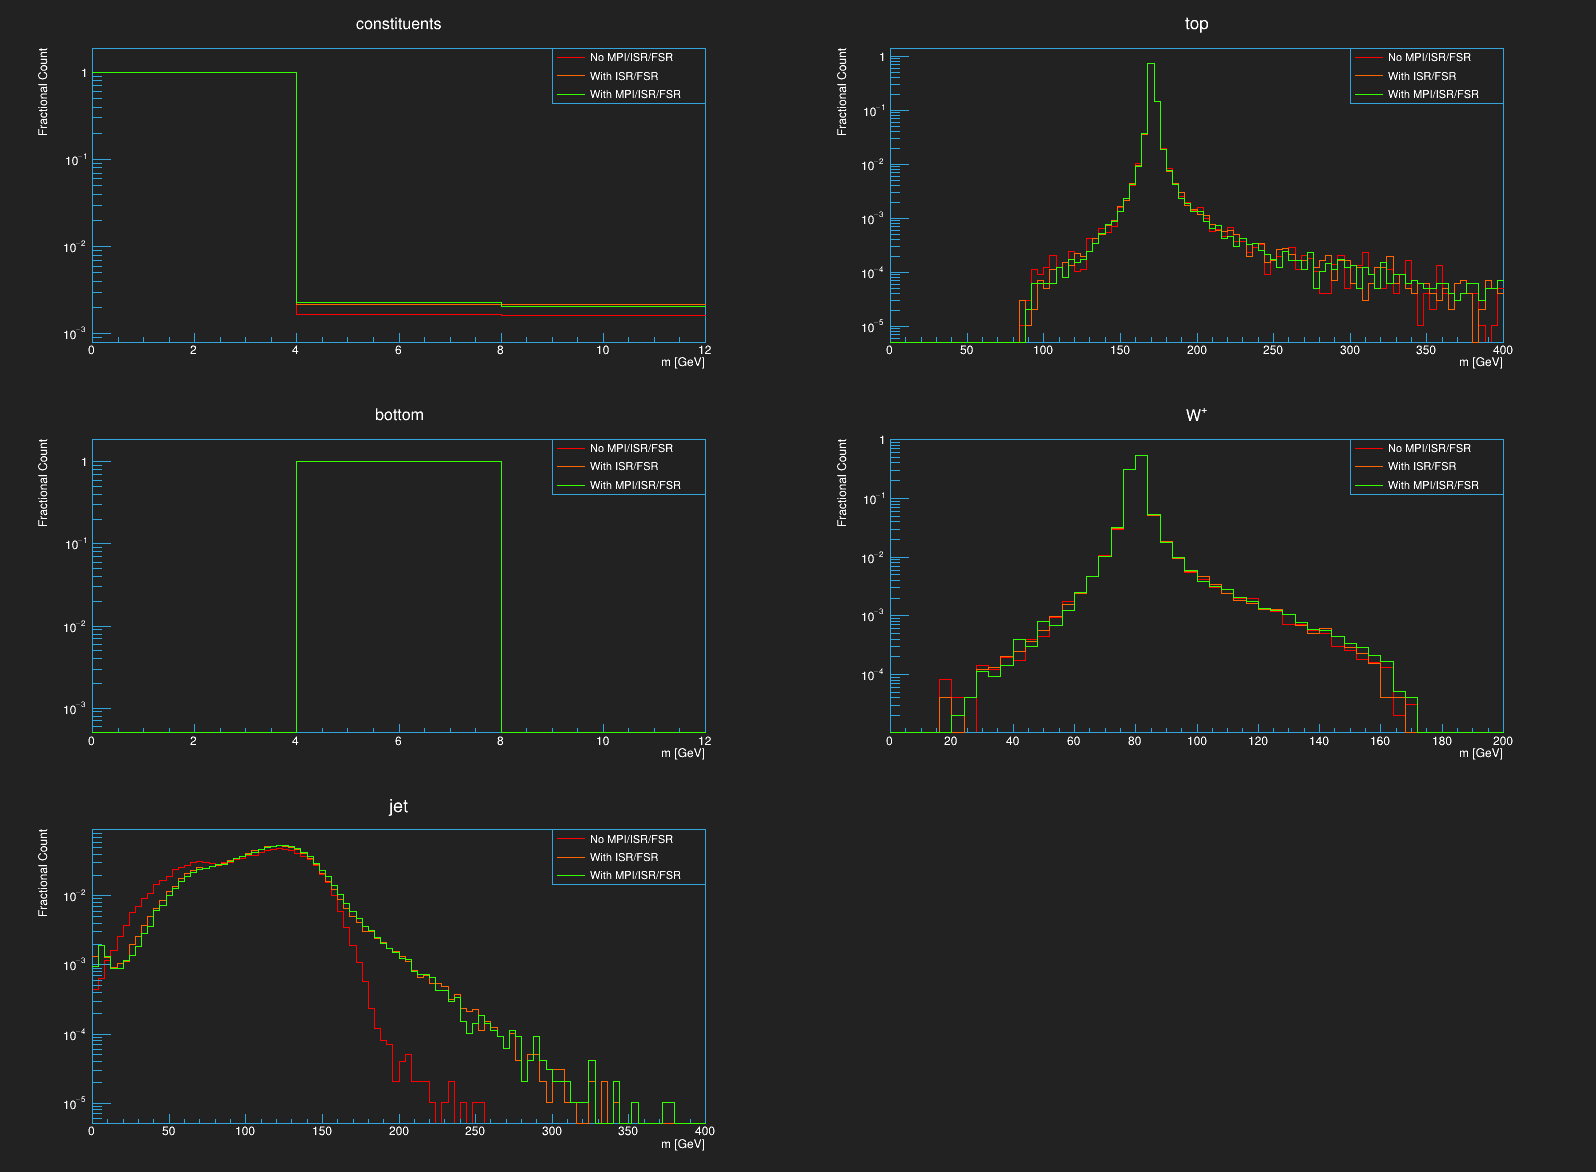

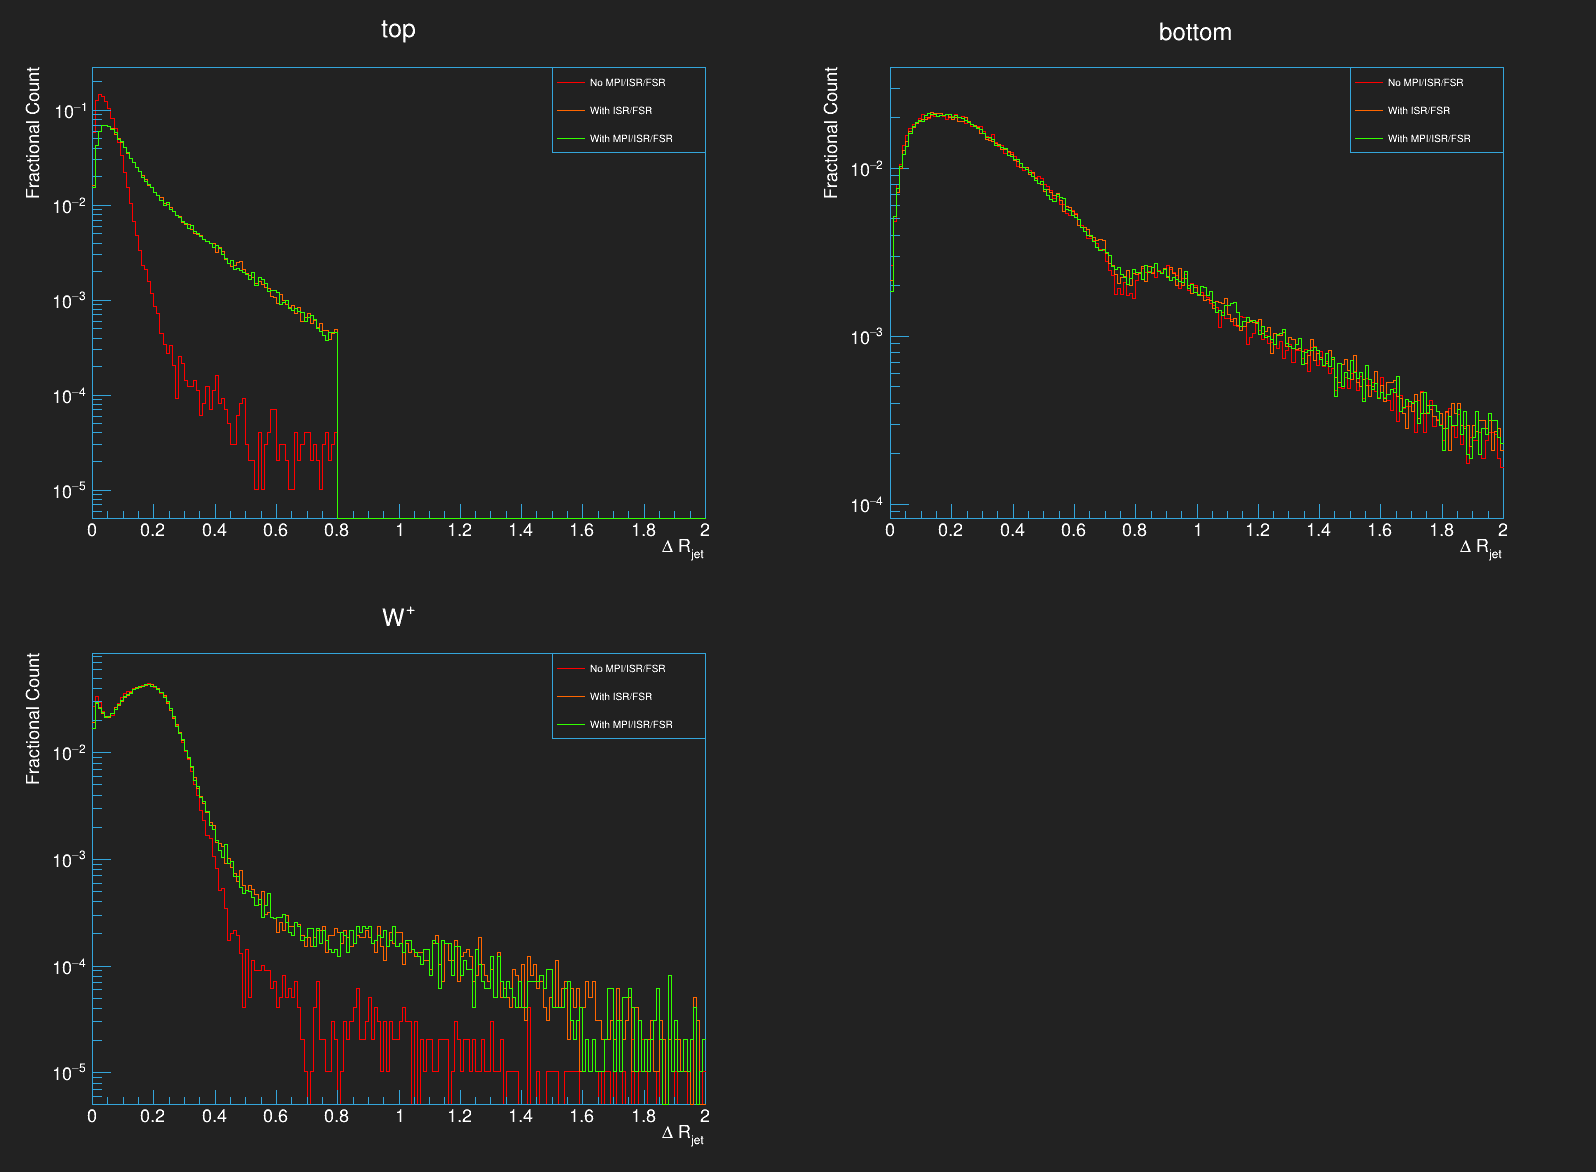

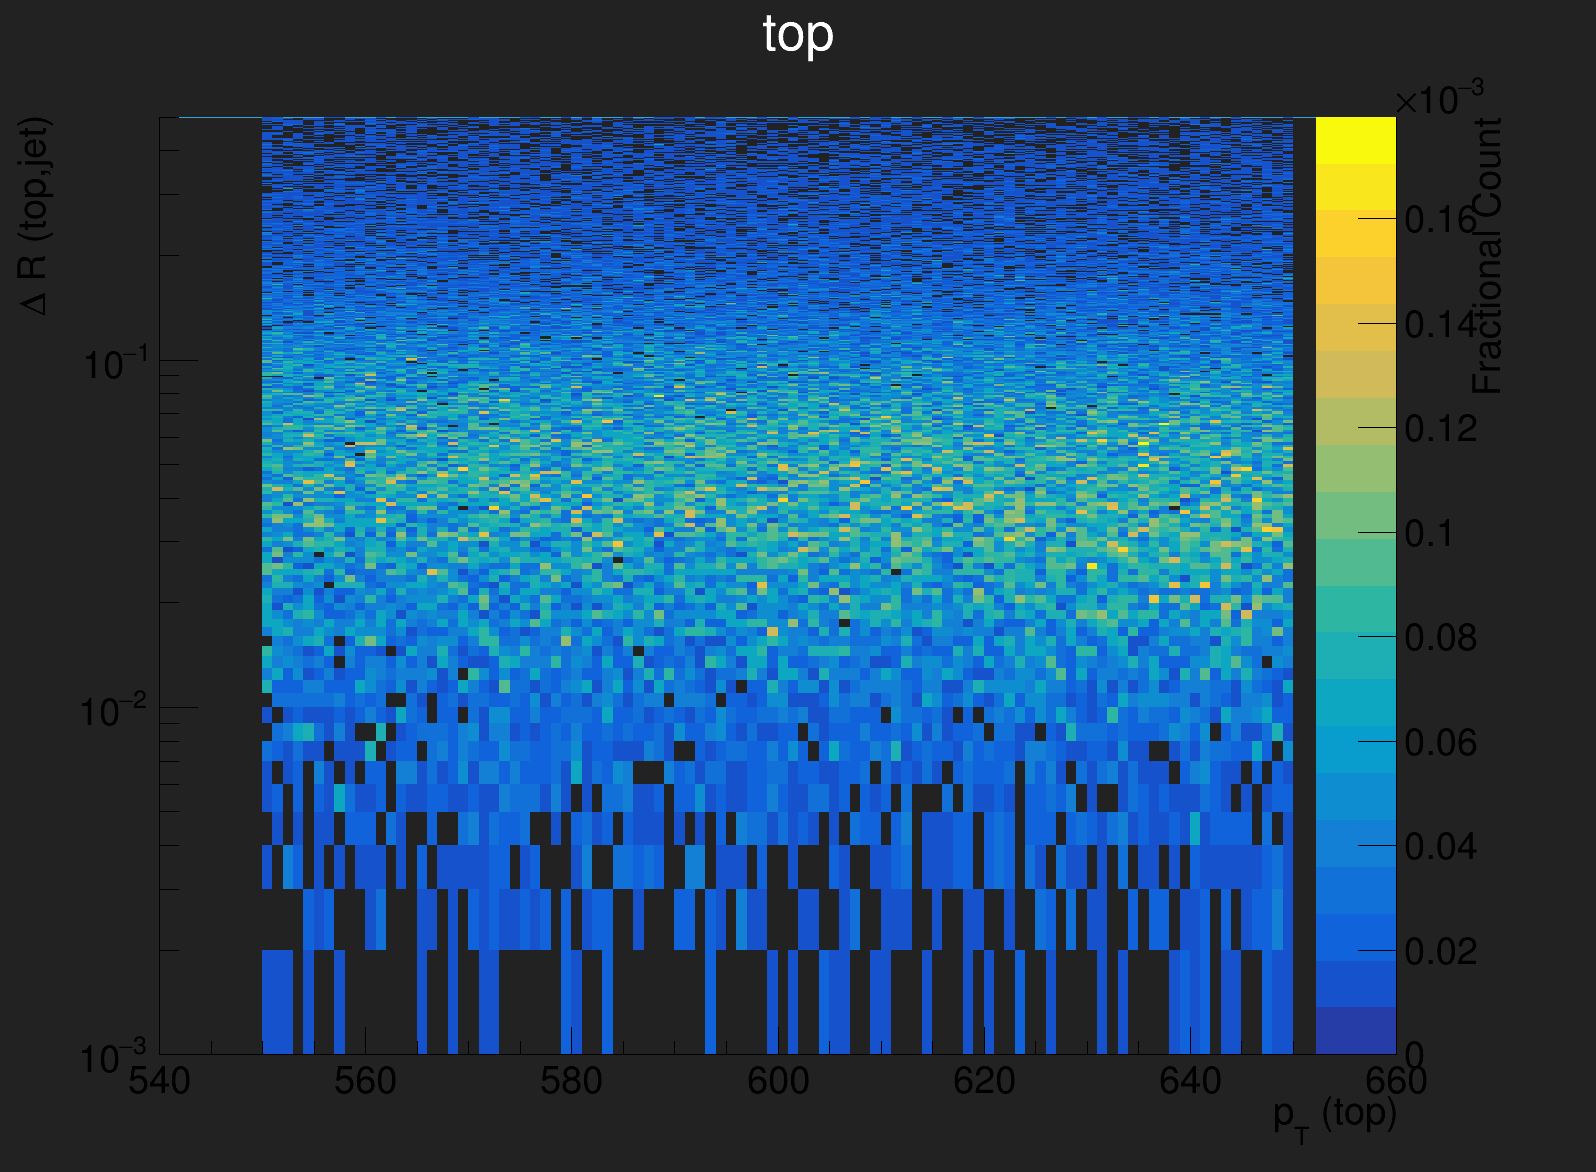

In [9]:
for i,c in enumerate(canvases): 
    c.Draw()
    c.SaveAs('{}.png'.format(plot_names[i]))

In [10]:
for x in rootfiles: x.Close()